# Importing Necesarry Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,cohen_kappa_score,roc_curve,roc_auc_score,classification_report,confusion_matrix,recall_score
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore')

# Importing the Data

In [2]:
df = pd.read_csv('data.csv')
df.head()

,id,label,tweet
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


### Basic Information About the Data :

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      99989 non-null  int64 
 1   label   99989 non-null  int64 
 2   tweet   99989 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


# Data Preprocessing

In [4]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
        input_txt=re.sub('[^A-Za-z0-9 ]+', ' ', input_txt) #Remove special-characters
        input_txt=re.sub(r"RT[\s]+","",input_txt) #Remove Re-tweet
        input_txt=re.sub(r"https?:\/\/\S+","",input_txt) #Remove links
    return input_txt

In [5]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*") 

# remove the words has char size less than 2
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>2])) 

In [6]:
from nltk.corpus import stopwords
stp_words=stopwords.words("english")
print(stp_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
from nltk.stem.snowball import SnowballStemmer
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split()) #splits words in the sentence

#iterate each word in list, if it is stopword it will include in the text  
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = [j for j in tokenized_tweet[i] if j not in stp_words] 
    
print("\n\t\tTokenized Tweet before Stemming\n\n",tokenized_tweet)

stemmer = SnowballStemmer(language="english")
#Text normalization technique
#Stemming removes prefix and suffix, then finds the root word of the particular word
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence]) 

print("\n\t\tTokenized Tweet after Stemming\n\n",tokenized_tweet)


		Tokenized Tweet before Stemming

 0                          [sad, APL, friend.............]
1                          [missed, New, Moon, trailer...]
2                                     [omg, already, 7:30]
3        [Omgaga., sooo, gunna, CRy., I've, dentist, si...
4                            [think, cheating, me!!!, T_T]
                               ...                        
99984    [seems, like, repeating, problem, hope, able, ...
99985    [arrrr, replied, different, tweets, time, see,...
99986                                            [thought]
99987                                [Yes, Yes, glad, fun]
99988                                          [haha, yes]
Name: clean_tweet, Length: 99989, dtype: object

		Tokenized Tweet after Stemming

 0                          [sad, apl, friend.............]
1                            [miss, new, moon, trailer...]
2                                     [omg, alreadi, 7:30]
3        [omgaga., sooo, gunna, cry., i'v, dentist, s

In [8]:
for i in range(len(tokenized_tweet)):
    # Here we combine the words in the list into one single sentences
    tokenized_tweet[i] = " ".join([j for j in tokenized_tweet[i]])
print(tokenized_tweet)

0                              sad apl friend.............
1                                 miss new moon trailer...
2                                         omg alreadi 7:30
3        omgaga. sooo gunna cry. i'v dentist sinc 11.. ...
4                                    think cheat me!!! t_t
                               ...                        
99984        seem like repeat problem hope abl find someth
99985    arrrr repli differ tweet time see duno hell ka...
99986                                              thought
99987                                       ye ye glad fun
99988                                              haha ye
Name: clean_tweet, Length: 99989, dtype: object


In [9]:
df['clean_tweet'] = tokenized_tweet
df.head()

,id,label,tweet,clean_tweet
0,1,0,is so sad for my APL frie...,sad apl friend.............
1,2,0,I missed the New Moon trail...,miss new moon trailer...
2,3,1,omg its already 7:30 :O,omg alreadi 7:30
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga. sooo gunna cry. i'v dentist sinc 11.. ...
4,5,0,i think mi bf is cheating on me!!! ...,think cheat me!!! t_t


# Data Visualization

### Most Frequent Words

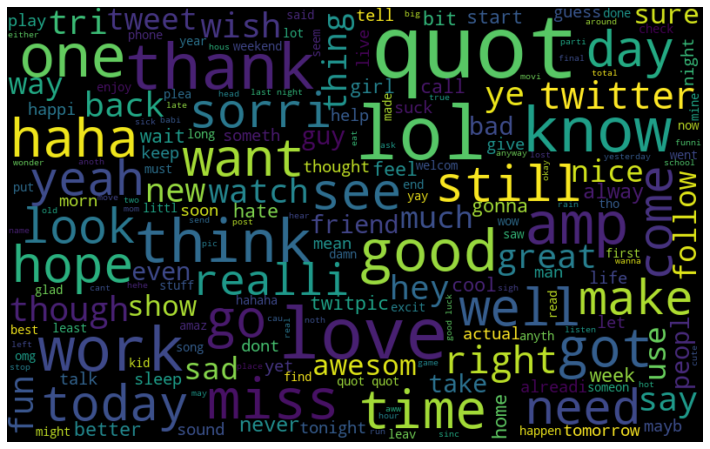

In [10]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Most Frequent Words in Negative Tweets

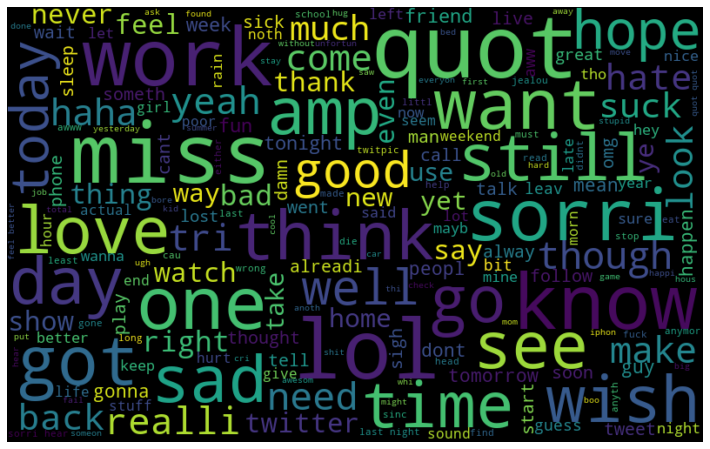

In [11]:
# frequent words visualization for +ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Most Frequent Words in Positive Tweets

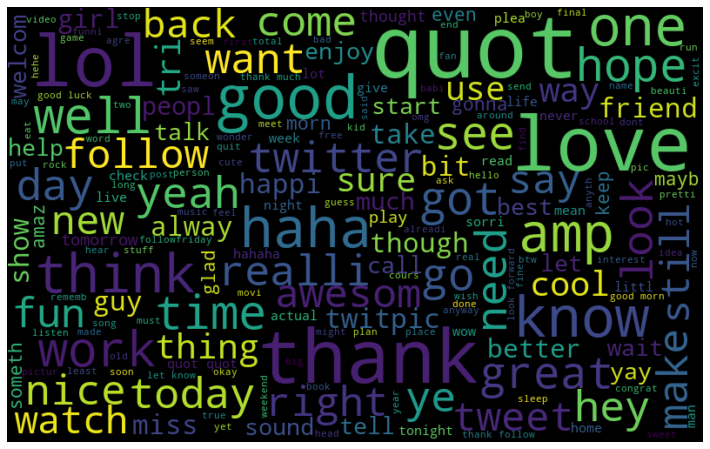

In [12]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Top Hashtags

In [13]:
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags    

In [14]:
# extract hashtags from non-racist/sexist tweets
ht_positive = hashtag_extract(df['clean_tweet'][df['label']==0])
# extract hashtags from racist/sexist tweets
ht_negative = hashtag_extract(df['clean_tweet'][df['label']==1])

In [15]:
# unnest list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

### Top Hashtags in Positive Tweets

In [16]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})

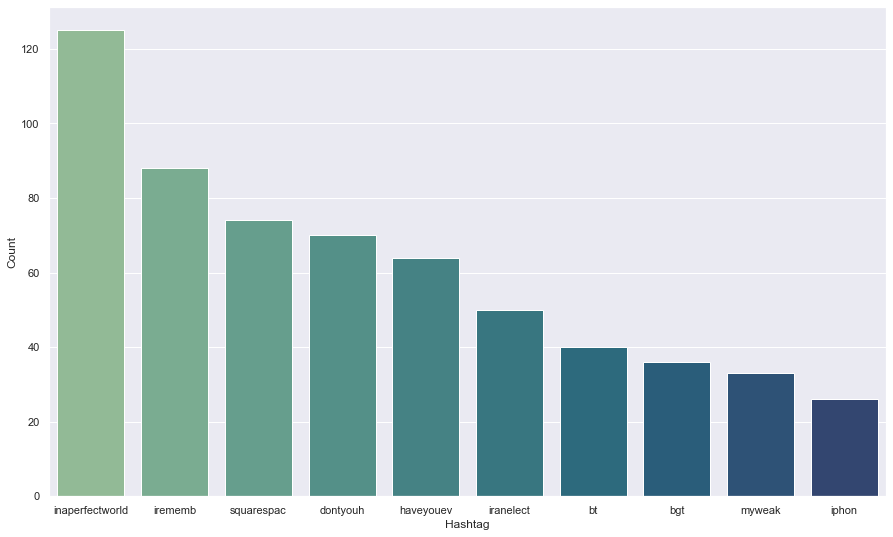

In [17]:
# select top 10 hashtags
sns.set_theme(style="darkgrid")
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count',palette= "crest")
plt.show()

### Top Hashtags in Negative Tweets

In [18]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})

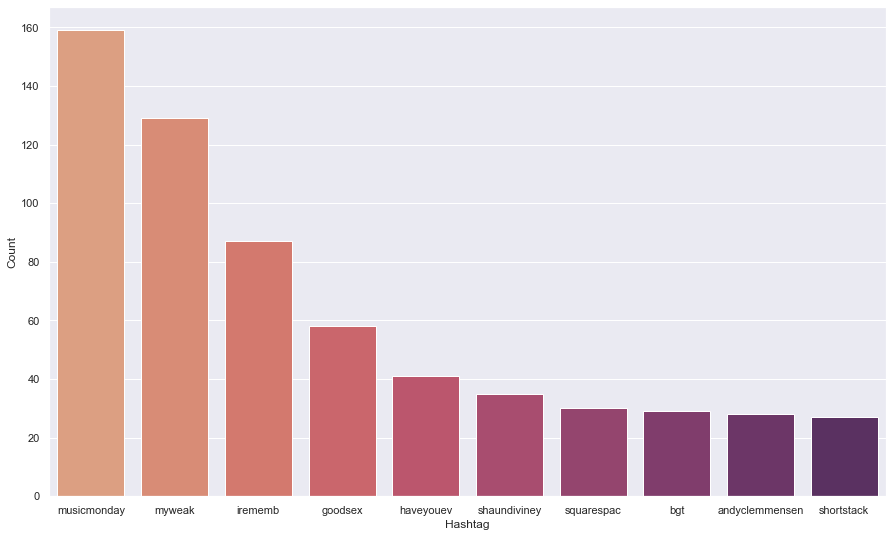

In [19]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count',palette= "flare")
plt.show()

### Counts of Positive and Negative Tweets

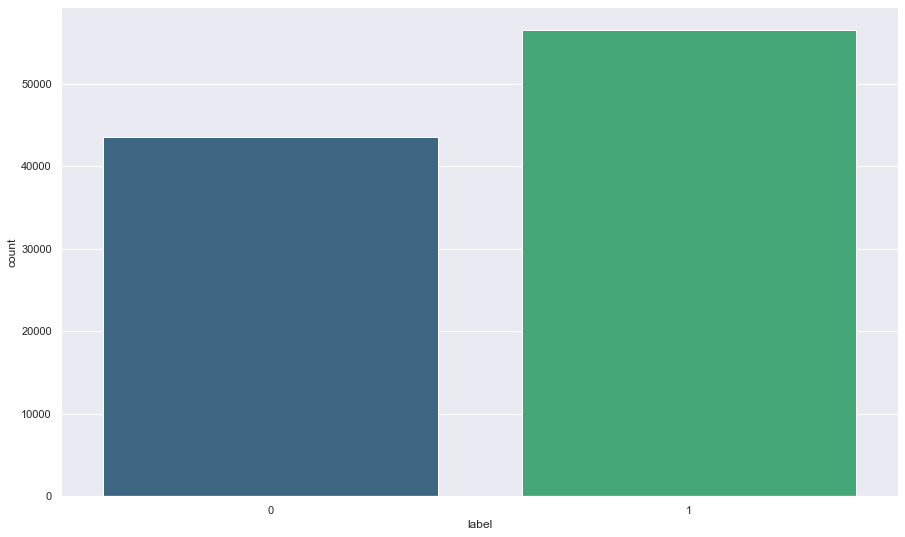

In [20]:
plt.figure(figsize=(15,9))
sns.countplot(x=df["label"], palette= "viridis")
plt.show()

Text(0.5, 1.0, 'Pie chart of Positive and Negative Class \n')

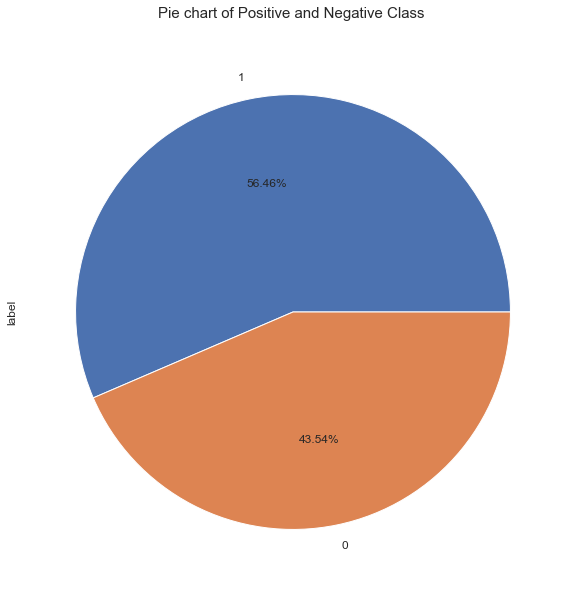

In [21]:
ax = df["label"].value_counts().plot.pie(figsize=(10,10), autopct='%1.2f%%', fontsize = 12)
ax.set_title("Pie chart of Positive and Negative Class" + ' \n', fontsize = 15)

# Data Preperation For Model Building

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000,stop_words="english")
vector=cv.fit(df['clean_tweet'])
x = vector.transform(df['clean_tweet'])
y=df['label']

# Train Test Split

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=100)

In [82]:
x_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Model Building

In [24]:
logi = LogisticRegression()
logi.fit(x_train,y_train)
predict_test=logi.predict(x_test)
predict_train=logi.predict(x_train)
logi_Accuracy_test=accuracy_score(y_test,predict_test)
logi_Accuracy_train=accuracy_score(y_train,predict_train)
print("Train Accuracy : {}\nTest Accuracy : {}".format(logi_Accuracy_train*100,logi_Accuracy_test*100))

Train Accuracy : 75.20430906389302
Test Accuracy : 72.97729772977297


In [25]:
naive=GaussianNB()
naive.fit(x_train.toarray(),y_train)
predict_test=naive.predict(x_test.toarray())
predict_train=naive.predict(x_train.toarray())
naive_Accuracy_test=accuracy_score(y_test,predict_test)
naive_Accuracy_train=accuracy_score(y_train,predict_train)
print("Train Accuracy : {}\nTest Accuracy : {}".format(naive_Accuracy_train*100,naive_Accuracy_test*100))

Train Accuracy : 70.61378443250658
Test Accuracy : 67.94012734606794


In [26]:
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
predict_test=xgb.predict(x_test)
predict_train=xgb.predict(x_train)
xgb_Accuracy_test=accuracy_score(y_test,predict_test)
xgb_Accuracy_train=accuracy_score(y_train,predict_train)
print("Train Accuracy : {}\nTest Accuracy : {}".format(xgb_Accuracy_train*100,xgb_Accuracy_test*100))

Train Accuracy : 76.36015544633672
Test Accuracy : 73.67070040337367


In [27]:
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
predict_test=rf.predict(x_test)
predict_train=rf.predict(x_train)
rf_Accuracy_test=accuracy_score(y_test,predict_test)
rf_Accuracy_train=accuracy_score(y_train,predict_train)
print("Train Accuracy : {}\nTest Accuracy : {}".format(rf_Accuracy_train*100,rf_Accuracy_test*100))

Train Accuracy : 98.57555149159904
Test Accuracy : 73.5973597359736


# Tuning and Validating the Model

In [28]:
def logistic_regression(x,y):    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=100)
    logi = LogisticRegression(n_jobs=3)
    logi.fit(x_train,y_train)
    predict_test=logi.predict(x_test)
    predict_train=logi.predict(x_train)
    logi_Accuracy_test=accuracy_score(y_test,predict_test)
    logi_Accuracy_train=accuracy_score(y_train,predict_train)
            logi_cohen_kappa=cohen_kappa_score(y_test,predict_test)
    logi_recall=recall_score(y_test,predict_test)
    print("Train : ",logi_Accuracy_train*100,"Test : ",logi_Accuracy_test*100)
    print("\nTrain Classification Report \n ",classification_report(y_train,predict_train))
    print("\nTest Classification Report \n",classification_report(y_test,predict_test))
    print("\nCohen's Kappa Score : ",logi_cohen_kappa)
    print("\nConfussion Matrix \n",confusion_matrix(y_test,predict_test))
    pred_prob=logi.predict_proba(x_test)[:,1]
    fpr,tpr,threshold=roc_curve(y_test,pred_prob)
    logi_auc_score = roc_auc_score(y_test, predict_test)
    print("\nauc_score",logi_auc_score)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--',label='Logistic Regression (area = %0.2f)' % logi_auc_score)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    model_name="Logistic_Regression"
    return logi,model_name,logi_Accuracy_test,logi_Accuracy_train,logi_cohen_kappa,logi_recall,logi_auc_score

Train :  77.04309063893017 Test :  74.84748474847484

Train Classification Report 
                precision    recall  f1-score   support

           0       0.77      0.68      0.72     30501
           1       0.77      0.84      0.81     39491

    accuracy                           0.77     69992
   macro avg       0.77      0.76      0.76     69992
weighted avg       0.77      0.77      0.77     69992


Test Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.65      0.69     13031
           1       0.75      0.82      0.79     16966

    accuracy                           0.75     29997
   macro avg       0.75      0.74      0.74     29997
weighted avg       0.75      0.75      0.75     29997


Cohen's Kappa Score :  0.48086513661263053

Confussion Matrix 
 [[ 8471  4560]
 [ 2985 13981]]

auc_score 0.7370625567719875


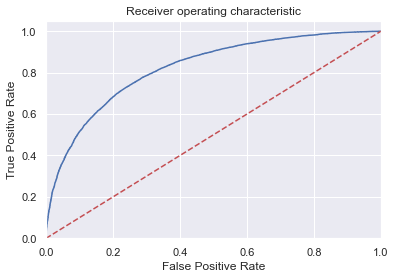

In [29]:
logi_model,logi_model_name,logi_Accuracy_test,logi_Accuracy_train,logi_cohen_kappa,logi_recall,logi_auc_score=logistic_regression(x,y)

In [30]:
def xgboost(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=100)
    estimator=XGBClassifier()
    param = {"n_estimators": [50,150,200],"max_depth":[20,30,40],"learning_rate":[0.05,0.1,0.2]}
    grid=GridSearchCV(estimator=estimator,param_grid=param,n_jobs=-1,cv=5,verbose=3)
    grid.fit(x_train,y_train)
    print(grid.best_score_)
    print(grid.best_params_)
    best_param=grid.best_params_
    xgb=XGBClassifier(n_estimators=best_param["n_estimators"],max_depth=best_param["max_depth"]
                             ,learning_rate=best_param["learning_rate"],n_jobs=-1)
    xgb.fit(x_train,y_train)
    predict_test=xgb.predict(x_test)
    predict_train=xgb.predict(x_train)
    xgb_Accuracy_test=accuracy_score(y_test,predict_test)
    xgb_Accuracy_train=accuracy_score(y_train,predict_train)
    xgb_cohen_kappa=cohen_kappa_score(y_test,predict_test)
    xgb_recall=recall_score(y_test,predict_test)
    print("Train : ",xgb_Accuracy_train*100,"Test : ",xgb_Accuracy_test*100)
    print("\nTrain Classification Report \n ",classification_report(y_train,predict_train))
    print("\nTest Classification Report \n",classification_report(y_test,predict_test))
    pred_prob=xgb.predict_proba(x_test)[:,1]
    fpr,tpr,throshold=roc_curve(y_test,pred_prob)
    xgb_auc_score = roc_auc_score(y_test, predict_test)
    print("\nCohen's Kappa Score : ",xgb_cohen_kappa)
    print("\nConfussion Matrix \n",confusion_matrix(y_test,predict_test))
    print("auc_score",xgb_auc_score)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--',label='Xg Boost (area = %0.2f)' % xgb_auc_score)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    model_name="XG_Boost"
    return xgb,model_name,xgb_Accuracy_test,xgb_Accuracy_train,xgb_cohen_kappa,xgb_recall,xgb_auc_score

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7504429893095155
{'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 200}
Train :  86.30986398445538 Test :  75.19418608527519

Train Classification Report 
                precision    recall  f1-score   support

           0       0.89      0.78      0.83     30501
           1       0.84      0.93      0.88     39491

    accuracy                           0.86     69992
   macro avg       0.87      0.85      0.86     69992
weighted avg       0.87      0.86      0.86     69992


Test Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.65      0.70     13031
           1       0.76      0.83      0.79     16966

    accuracy                           0.75     29997
   macro avg       0.75      0.74      0.74     29997
weighted avg       0.75      0.75      0.75     29997


Cohen's Kappa Score :  0.4876138971658601

Confussion Matrix 
 [[ 8479  4552]
 [ 2889 14

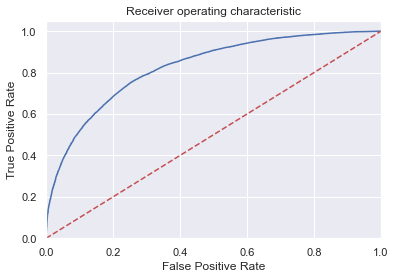

In [31]:
xgb_model,xgb_model_name,xgb_Accuracy_test,xgb_Accuracy_train,xgb_cohen_kappa,xgb_recall,xgb_auc_score=xgboost(x,y)

In [32]:
def random_forest(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=100)
    estimator=RandomForestClassifier()
    param = {"n_estimators": [100,200,300],"max_depth":[30,50,70]}
    grid=GridSearchCV(estimator=estimator,param_grid=param,n_jobs=-1,cv=5,verbose=3)
    grid.fit(x_train,y_train)
    print(grid.best_score_)
    print(grid.best_params_)
    best_param=grid.best_params_
    rf=RandomForestClassifier(n_estimators=best_param["n_estimators"],max_depth=best_param["max_depth"])
    rf.fit(x_train,y_train)
    predict_test=rf.predict(x_test)
    predict_train=rf.predict(x_train)
    rf_Accuracy_test=accuracy_score(y_test,predict_test)
    rf_Accuracy_train=accuracy_score(y_train,predict_train)
    rf_cohen_kappa=cohen_kappa_score(y_test,predict_test)
    rf_recall=recall_score(y_test,predict_test)
    print("Train : ",rf_Accuracy_train*100,"Test : ",rf_Accuracy_test*100)
    print("\nTrain Classification Report \n ",classification_report(y_train,predict_train))
    print("\nTest Classification Report \n",classification_report(y_test,predict_test))
    pred_prob=rf.predict_proba(x_test)[:,1]
    fpr,tpr,throshold=roc_curve(y_test,pred_prob)
    rf_auc_score = roc_auc_score(y_test, predict_test)
    print("\nCohen's Kappa Score : ",rf_cohen_kappa)
    print("\nConfussion Matrix \n",confusion_matrix(y_test,predict_test))
    print("auc_score",rf_auc_score)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--',label='Random Forest (area = %0.2f)' % rf_auc_score)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    model_name="Random_forest"
    return rf,model_name,rf_Accuracy_test,rf_Accuracy_train,rf_cohen_kappa,rf_recall,rf_auc_score

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.7304407124951192
{'max_depth': 70, 'n_estimators': 300}
Train :  86.7513430106298 Test :  73.17731773177317

Train Classification Report 
                precision    recall  f1-score   support

           0       0.95      0.73      0.83     30501
           1       0.82      0.97      0.89     39491

    accuracy                           0.87     69992
   macro avg       0.89      0.85      0.86     69992
weighted avg       0.88      0.87      0.86     69992


Test Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.58      0.65     13031
           1       0.72      0.85      0.78     16966

    accuracy                           0.73     29997
   macro avg       0.74      0.71      0.72     29997
weighted avg       0.73      0.73      0.73     29997


Cohen's Kappa Score :  0.4397236155823222

Confussion Matrix 
 [[ 7561  5470]
 [ 2576 14390]]
auc_score 0.7141993

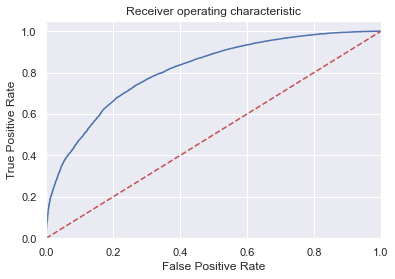

In [33]:
rf_model,rf_model_name,rf_Accuracy_test,rf_Accuracy_train,rf_cohen_kappa,rf_recall,rf_auc_score=random_forest(x,y)

### Saving the Model

In [34]:
import pickle

In [35]:
with open("logi_model.pkl",'wb') as f:
    pickle.dump(logi_model,f)
with open("rf_model.pkl",'wb') as f:
    pickle.dump(rf_model,f)
with open("xgboost_model.pkl",'wb') as f:
    pickle.dump(xgb_model,f)
with open("vector.pkl",'wb') as f:
    pickle.dump(vector,f)